Data split into test and train data - 80:20 


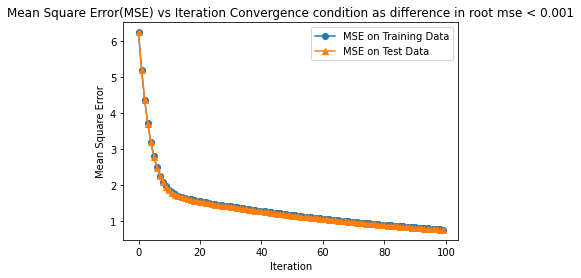

Mean Square Error : [[0.75433257]]
RSquare value : [[-2.81432796]]
Mean Square Error :  0.2548231711877007
Final Weight values :
 [[ 0.2698584 ]
 [ 0.44635825]
 [ 0.86805016]
 [ 0.41497912]
 [ 0.70868133]
 [ 0.4442023 ]
 [ 0.20297124]
 [-0.08423137]]


In [1]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale as mms
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as err
import sys


class EnhancedGradientDecent:
    def __init__(self, uri=None):
        np.random.seed(1)
        self.extractAndInitalizeData(uri)
        df = self.readCsv("train.csv")
        df.insert(0, 'X0', 1)
        self.nrows, self.ncols = df.shape[0], df.shape[1]
        self.X =  df.iloc[:, 0:(self.ncols -1)].values.reshape(self.nrows, self.ncols-1)
        self.y = df.iloc[:, (self.ncols-1)].values.reshape(self.nrows, 1)
        self.W = np.random.rand(self.ncols-1).reshape(self.ncols-1, 1)
        self.M = np.zeros(self.ncols-1).reshape(self.ncols-1, 1)
        self.normalize = 1
        self.epsilon = 10**-7

    def extractAndInitalizeData(self, data_set_file_name):
        try:
            df = self.readCsv(data_set_file_name)
            df = self.preProcessData(df)
            self.randomSplitData(df)
        except Exception as excep:
            print("Exception occurred while reading the given dataset file : ", excep)
            exit(0)


    def randomSplitData(self, df):
        df['index'] = df.reset_index().index
        testingDf = df.sample(frac=.20)
        df = df.drop(testingDf['index'])
        df = df.drop('index', 1)
        testingDf = testingDf.drop('index', 1)
        testingDf.to_csv('test.csv', index=False)
        df.to_csv('train.csv', index=False)
        print("Data split into test and train data - 80:20 ")

    def preProcessData(self, df):

        df = self.insertCategoricalValues(df)
        df = self.changeDateAndTimeFormat(df)
        if 'weather_description' in df.columns:
            df = self.removeColumn(df, "weather_description")
        df = self.minmaxNormalization(df, ['temp', 'rain_1h', 'clouds_all', 'traffic_volume'])
        return df


    def insertCategoricalValues(self, df):

        if 'weather_main' in df.columns:
            df['weather_main'] = df['weather_main'].map({
                'Clouds': 0,
                'Clear': 1,
                'Drizzle': 2,
                'Fog': 3,
                'Haze': 4,
                'Mist': 5,
                'Rain': 6,
                'Smoke': 7,
                'Snow': 8,
                'Squall': 9,
                'Thunderstorm': 10,
            }).fillna(df['weather_main'])

        if 'holiday' in df.columns:
            df['holiday'] = df['holiday'].map({
                'None': 0,
                'Columbus Day': 1,
                'Veterans Day': 2,
                'Thanksgiving Day': 3,
                'Christmas Day': 4,
                'New Years Day': 5,
                'Washingtons Birthday': 6,
                'Memorial Day': 7,
                'Independence Day': 8,
                'State Fair': 9,
                'Labor Day': 10,
                'Martin Luther King Jr Day': 11
            }).fillna(df['holiday'])
        return df

    def changeDateAndTimeFormat(self, df):
        df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
        df['date_time'] = df['date_time'].dt.hour
        return df

    def removeColumn(self, df, columnName):
        return df.drop(columns=columnName)

    def minmaxNormalization(self, df, columnNames):

        df[columnNames] = mms(df[columnNames])
        return df

    def readCsv(self, csvFileName):
        return pd.read_csv(csvFileName)

    def trainModel(self, epochs, learning_rate, do_plot_graph=False):

        mseArray = np.empty([1])
        msetestArray = np.empty([1])
        iterationArray = np.empty([1])
        error=0
        for i in range(epochs):
            h = np.dot(self.X, self.W)
            error = h - self.y
            
            self.M = self.M + ((1 / float(self.nrows)) *  np.dot(self.X.T, error)**2)
            param = learning_rate /(((self.M+self.epsilon)**2)**self.normalize)
            self.W = self.W - (param  * (1 / float(self.nrows)) *  np.dot(self.X.T, error))
            self.W = self.W - (1 / float(self.nrows)) * learning_rate * np.dot(self.X.T, error)
            
            localmse,localRSquare = model.testModel("train.csv")
            localmsetest, localRSquaretest = model.testModel("test.csv")
            mseArray = np.append(mseArray,localmse.flatten(),0)
            msetestArray = np.append(msetestArray,localmsetest.flatten(),0)
            iterationArray = np.append(iterationArray,i)
            if mseArray.size>2 and mseArray[mseArray.size-2]-mseArray[mseArray.size-1] < 0.001 :
                print("Converging at epoch ",i)
                break
        iterationArray =  np.delete(iterationArray,0)
        mseArray = np.delete(mseArray, 0)
        msetestArray = np.delete(msetestArray, 0)
        if do_plot_graph:
            plt.plot(iterationArray,mseArray,linestyle='-',marker='o')
            plt.plot(iterationArray,msetestArray,linestyle='-',marker='^')
            plt.xlabel("Iteration")
            plt.ylabel("Mean Square Error")
            plt.title("Mean Square Error(MSE) vs Iteration Convergence condition as difference in root mse < 0.001")
            plt.legend(['MSE on Training Data', 'MSE on Test Data'], loc='upper right')
            plt.show()
        localmse, localRSquare = self.testModel("train.csv")
        return self.W, error,i,localmse.flatten()[0]

    def testModel(self, datasetfile):
        dataFrame = pd.read_csv(datasetfile)
        dataFrame.insert(0, "X0", 1)
        nrows, ncols = dataFrame.shape[0], dataFrame.shape[1]
        testX = dataFrame.iloc[:, 0:(ncols - 1)].values.reshape(nrows, ncols - 1)
        testY = dataFrame.iloc[:, (ncols-1)].values.reshape(nrows, 1)
        pred = np.dot(testX, self.W)
        error = pred - testY
        mse = np.sqrt(((1/float(2*nrows)) * np.dot(np.transpose(error), error)))
        RSS = np.dot(np.transpose(error), error)
        TSS = self.findTSS()
        rSquare = 1 - (RSS/TSS)
        return mse,rSquare

    def findTSS(self):
        meanOfY = np.mean(self.y)
        summation = np.sum(np.square((self.y - np.full((self.nrows,1),meanOfY))))
        return float(summation)





    def sdgRegressor(self, max_iterations, learning_rate, file_name):

        testDF = pd.read_csv(file_name)
        testDF.insert(0, "X0", 1)
        nrows, ncols = testDF.shape[0], testDF.shape[1]
        testX = testDF.iloc[:, 0:(ncols - 1)].values.reshape(nrows, ncols - 1)
        testY = testDF.iloc[:, (ncols - 1)].values.reshape(nrows, 1)

        clf = lm.SGDRegressor(max_iter=max_iterations, eta0=learning_rate, learning_rate='constant')
        clf.fit(self.X, self.y.flatten())
        outputY = clf.predict(testX)
        return np.sqrt(err(testY,outputY))




if __name__ == "__main__":
    do_plot_graph = True

    epoch = 100
    lr = 0.001
    dataset_file_name = "https://cs6375assignments.s3.amazonaws.com/assignments/assignment-1/dataset.csv"
    model = EnhancedGradientDecent(uri=dataset_file_name)
    globalW = model.W
    W, e, i, tmse = model.trainModel(epochs=epoch, learning_rate=lr, do_plot_graph=do_plot_graph)
    testmse, rSquare = model.testModel("test.csv")
    sdgMSEError = model.sdgRegressor(epoch, lr, "train.csv")
    print("Mean Square Error :",testmse)
    print("RSquare value :",rSquare)
    print("Mean Square Error : ",sdgMSEError)
    print("Final Weight values :\n",W)

    
